# Problem 9.3

**Integrated Energy Grids**

**For the model built in PyPSA described in Problem 9.2, remove the CCGT with fix capacity, solve the optimization problem and:**

**a) Calculate the revenues collected by the OCGT plant throughout the year and show that their sum is equal to its costs.**

**b) Solve the problem for different CO$_2$ values ranging from 5 MtCO2/year to zero. Plot the total system cost and the required CO$_2$ prices as a function of the emissions allowance.**


:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

:::{note}
See also https://model.energy.
:::

In this exercise, we want to build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. We deviate from [model.energy](https://model.energy) by including electricity demand profiles rather than a constant electricity demand. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

Now we can for example read the capital and marginal cost of onshore wind and solar, or the emissions factors of the carrier gas used in and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "CO2 intensity"] #tCO2/MWh_th

np.float64(0.198)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [12]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [13]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal in this excercise

In [14]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [15]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
      "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. 

In [16]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [17]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

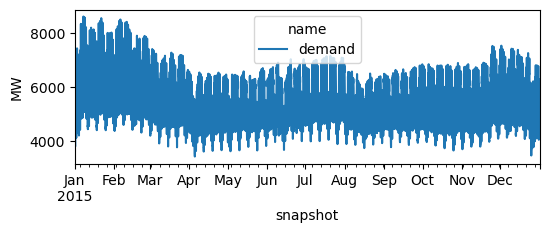

In [18]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [19]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

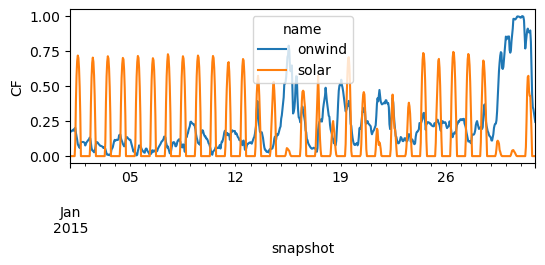

In [20]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For the capital cost, we have to factor in both the capacity and energy cost of the storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [21]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

### Model Run

Before solving the problem we add a CO$_2$ emission limit as global constraint:

In [22]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=5000000, #5MtCO2
)

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [23]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 70.05it/s]
INFO:linopy.io: Writing time: 2.48s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-zf1czb1k has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 5e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      15967     1.6232060862e+09 Pr: 13100(7.88994e+07); Du: 0(7.87717e-08) 7s
      20319     1.7201531021e+09 Pr: 34327(1.74604e+09); Du: 0(7.87717e-08) 12s
      25252     2.0433

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.48e+09
Solver model: available
Solver message: Optimal



      51357     3.4750583556e+09 Pr: 0(0); Du: 0(2.43844e-10) 48s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-zf1czb1k
Model status        : Optimal
Simplex   iterations: 51357
Objective value     :  3.4750583556e+09
P-D objective error :  5.6945064046e-15
HiGHS run time      :         48.28


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [24]:
n.objective / 1e9
n.global_constraints

,type,investment_period,bus,carrier_attribute,sense,constant,mu
name,,,,,,,
CO2Limit,primary_energy,NaN,,co2_emissions,<=,5000000.0,-107.043318


**a) Calculate the revenues collected by the OCGT plant throughout the year and show that their sum is equal to its costs.**

To calculate the revenues collected by every technology, we multiply the energy generated in every hour by the electricity price in that hour and sum for the entire year.

In [25]:
n.generators_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

name
OCGT      1419.474028
onwind    1346.159208
solar      673.717868
dtype: float64

To calculate the tax paid by the OCGT generator, we mutiply the sum of the energy generated by its emission factor, and the CO2 price. 

In [26]:
(-n.global_constraints.mu)*n.generators_t.p.sum()['OCGT']*costs.at["OCGT", "CO2 intensity"]/costs.at["OCGT", "efficiency"]*0.000001 #tCO2/MtCO2

name
CO2Limit    535.21659
Name: mu, dtype: float64

The market revenues, minus what is paid in CO2 tax,corresponds to the total cost for OCGT, which we can also read using the statistics module:

In [27]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component    carrier        
Generator    OCGT                884.257438
             onwind             1346.159208
             solar               673.717868
StorageUnit  battery storage            NaN
dtype: float64

**b) Solve the problem for different CO$_2$ values ranging from 5 MtCO2/year to zero. Plot the total system cost and the required CO$_2$ prices as a function of the emissions allowance.**

In [28]:
sensitivity = {}
co2_price = pd.Series()
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a
    
for co2 in [5, 4, 3, 2, 1, 0]:
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="highs")
    sensitivity[co2] = system_cost(n)
    co2_price[co2] = -n.global_constraints.mu['CO2Limit']

Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 125.56it/s]
INFO:linopy.io: Writing time: 0.45s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-7sionujd has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 5e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      21705     1.9435131116e+09 Pr: 11137(6.00678e+07); Du: 0(1.53258e-07) 5s
      38749     2.9161198144e+09 Pr: 41520(1.12316e+09); Du: 0(1.53258e-07) 10s
      42196     3.2747

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.48e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['electricity'], dtype='object', name='name')



Model name          : linopy-problem-7sionujd
Model status        : Optimal
Simplex   iterations: 51357
Objective value     :  3.4750583556e+09
P-D objective error :  5.6945064046e-15
HiGHS run time      :         26.61


Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 88.88it/s]
INFO:linopy.io: Writing time: 0.59s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-p9v6dvj6 has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 4e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      22025     2.0620752921e+09 Pr: 31604(1.70213e+08); Du: 0(1.53258e-07) 5s
      38481     2.8470087726e+09 Pr: 15072(1.97182e+08); Du: 0(1.34222e-07) 11s
      44178     3.4163

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.59e+09
Solver model: available
Solver message: Optimal



      51072     3.5926843487e+09 Pr: 100(3035.98); Du: 0(6.1213e-08) 21s
      51135     3.5926607339e+09 Pr: 0(0); Du: 0(1.16335e-12) 21s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-p9v6dvj6
Model status        : Optimal
Simplex   iterations: 51135
Objective value     :  3.5926607339e+09
P-D objective error :  2.1302418890e-14
HiGHS run time      :         21.41


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 214.20it/s]
INFO:linopy.io: Writing time: 0.33s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-h13g1661 has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 3e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      20149     2.0960589318e+09 Pr: 12459(1.0054e+08); Du: 0(1.82364e-08) 5s
      31248     2.6744000283e+09 Pr: 19427(1.38998e+08) 10s
      36853     3.4053780523e+09 Pr: 39750(

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.75e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


      43522     3.7489679388e+09 Pr: 0(0); Du: 0(2.85343e-11) 23s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-h13g1661
Model status        : Optimal
Simplex   iterations: 43522
Objective value     :  3.7489679388e+09
P-D objective error :  1.4563435990e-14
HiGHS run time      :         23.31


Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 256.21it/s]
INFO:linopy.io: Writing time: 0.81s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-phr6_14g has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 2e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      17117     2.4706981084e+09 Pr: 21499(1.92465e+08); Du: 0(1.9671e-18) 5s
      23394     2.5154271694e+09 Pr: 20944(9.81848e+08); Du: 0(8.44475e-08) 11s
      31069     3.01216

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.97e+09
Solver model: available
Solver message: Optimal



      41953     3.9661391062e+09 Pr: 9(49.6718) 27s
      41962     3.9660900291e+09 Pr: 0(0); Du: 0(7.75869e-14) 27s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-phr6_14g
Model status        : Optimal
Simplex   iterations: 41962
Objective value     :  3.9660900291e+09
P-D objective error :  8.2356540303e-15
HiGHS run time      :         26.67


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 198.14it/s]
INFO:linopy.io: Writing time: 0.29s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-ta1pkn3t has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 1e+06]
Presolving model
65719 rows, 48202 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 48202 cols, 179634 nonzeros  0s
Presolve reductions: rows 65719(-56926); columns 48202(-4362); nonzeros 179634(-61288) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      18268     2.7903923450e+09 Pr: 9690(2.08214e+09); Du: 0(1.13255e-18) 5s
      25723     2.9356307772e+09 Pr: 19290(2.10455e+08); Du: 0(2.52988e-08) 11s
      34099     4.12369

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.39e+09
Solver model: available
Solver message: Optimal



      39448     4.3857035133e+09 Pr: 0(0); Du: 0(2.11208e-11) 20s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-ta1pkn3t
Model status        : Optimal
Simplex   iterations: 39448
Objective value     :  4.3857035133e+09
P-D objective error :  2.4571929547e-14
HiGHS run time      :         20.24


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 219.69it/s]
INFO:linopy.io: Writing time: 0.33s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-qe8c3xcn has 122645 rows; 52564 cols; 240922 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 9e+03]
Presolving model
56958 rows, 39441 cols, 144594 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
56958 rows, 39441 cols, 144594 nonzeros  0s
Presolve reductions: rows 56958(-65687); columns 39441(-13123); nonzeros 144594(-96328) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      22127     1.4899407082e+09 Pr: 11483(2.49157e+09); Du: 0(5.72207e-19) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 6.62e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


      41221     6.6204913061e+09 Pr: 0(0); Du: 0(4.55556e-12) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-qe8c3xcn
Model status        : Optimal
Simplex   iterations: 41221
Objective value     :  6.6204913061e+09
P-D objective error :  4.1774173388e-15
HiGHS run time      :          6.22


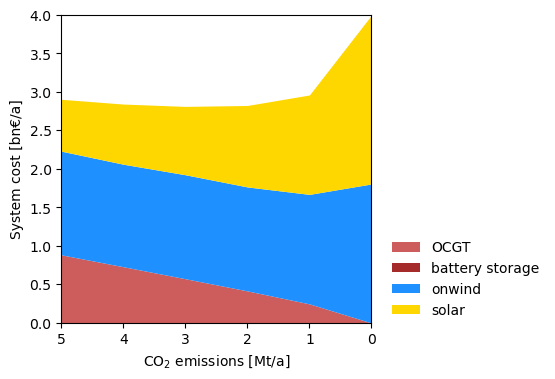

In [29]:
df = pd.DataFrame(sensitivity).T.div(1e3)  # billion Euro/a
df.plot.area(
    stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color),
    figsize=(4, 4),
    xlim=(0, 5),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 4),
)
plt.legend(frameon=False, loc=(1.05, 0))
plt.gca().invert_xaxis()

(0.0, 1000.0)

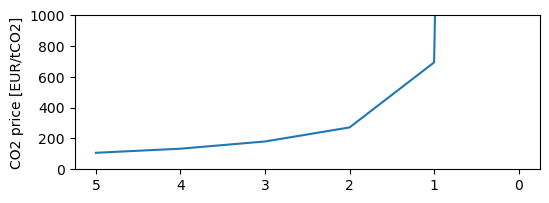

In [30]:
co2_price.plot(figsize=(6, 2), ylabel="CO2 price [EUR/tCO2]")
plt.gca().invert_xaxis()
plt.ylim([0,1000])